# KMeans for player clustering

In this notebook, we will train an unsupervised machine learning algorithm called KMeans.

KMeans is capable of discovering patterns in data and creating groups of similar data points.

In this notebook, we will use a dataset I scraped from FBREF on my own.

This dataset contains midfielders of the argentinian league. We want to cluster players that share similar characteristics. For example, more defensive, more offensive, playmaker, etc.

First we import the necessary packages.

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Let's start by reading the dataset using pandas and examining what we have at our disposal:


In [63]:
players_df = pd.read_csv('FBRef_2024_CopaDeLaLiga_MidfieldersAnalysis.csv')
players_df.head()

,Unnamed: 0,Rk,Player,Nation,Pos,Squad,Age,Born,Matches Played,Starts,...,Interceptions,Passes Blocked,Shots Blocked,Tackles,Tackles Att 3rd,Tackles Def 3rd,Tackles Mid 3rd,Tackles Won,Tackles+Interceptions,Total Blocks
0,0,1,Matías Abaldo,uy URU,"MF,FW",Gimnasia ELP,20-025,2004,7,5,...,2,4,0,4,1,3,0,2,6,4
1,1,2,Luciano Abecasis,ar ARG,"MF,DF",Independiente Rivadavia,33-329,1990,12,10,...,2,10,1,19,0,4,15,11,21,11
2,2,3,Ramón Ábila,ar ARG,FW,Barracas Central,34-197,1989,9,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,Jonás Acevedo,ar ARG,"MF,FW",Instituto,27-082,1997,9,6,...,3,6,1,13,4,5,4,7,16,7
4,4,5,Guillermo Acosta,ar ARG,MF,Tucumán,35-180,1988,10,10,...,12,3,1,17,0,5,12,9,29,4


We check the column names, non-null count and types

In [64]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 88 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    797 non-null    int64 
 1   Rk                            797 non-null    object
 2   Player                        797 non-null    object
 3   Nation                        788 non-null    object
 4   Pos                           796 non-null    object
 5   Squad                         797 non-null    object
 6   Age                           788 non-null    object
 7   Born                          788 non-null    object
 8   Matches Played                797 non-null    object
 9   Starts                        797 non-null    object
 10  Min                           797 non-null    object
 11  90s                           797 non-null    object
 12  Gls                           797 non-null    object
 13  Ast                 

Which are the metrics that are going to help our algorithm cluster the different type of midfielders?
We exclude metrics that are not significant and will hinder our algorithm.
We excluded de 90' metrics, we are going to convert them all later.
We also excluded accuracy metrics, for example, the number of correct passes will not help us deduce the different type of midfielders.

In [65]:
metrics = ['Player', "Min", 'Gls', 'Ast', 'xG', 'xAG',
       'Progressive Carries', 'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attenpted', 'Total Passing Distance', 'xA',
       'Passes Completed', 'Switches', 'Through Balls',
       'Clearances',
       'Interceptions', 'Passes Blocked', 'Shots Blocked', 'Tackles', 'Total Blocks']

players_df = players_df[metrics]
players_df.columns

Index(['Player', 'Min', 'Gls', 'Ast', 'xG', 'xAG', 'Progressive Carries',
       'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attenpted',
       'Total Passing Distance', 'xA', 'Passes Completed', 'Switches',
       'Through Balls', 'Clearances', 'Interceptions', 'Passes Blocked',
       'Shots Blocked', 'Tackles', 'Total Blocks'],
      dtype='object')

Convert all columns to numeric, excluding the "player column"

In [66]:
players_df.iloc[:, 1:] = players_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

Players that did not play sufficient amount of minutes will have data that may not be accurate to the player. We exclude players with less than 400 minutes played that season.

In [67]:
# Filter the DataFrame for rows where 'Min' > 400
players_df = players_df[players_df['Min'] > 400]
players_df.reset_index(inplace=True, drop=True)

players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Player                        402 non-null    object
 1   Min                           402 non-null    object
 2   Gls                           402 non-null    object
 3   Ast                           402 non-null    object
 4   xG                            380 non-null    object
 5   xAG                           380 non-null    object
 6   Progressive Carries           380 non-null    object
 7   Progressive Passes            380 non-null    object
 8   Crosses into Penalty Area     380 non-null    object
 9   Key Passes                    380 non-null    object
 10  Long Passes Attempted         380 non-null    object
 11  Medium Passes Attempted       380 non-null    object
 12  Passes into Final Third       380 non-null    object
 13  Passes into Penalty 

We want to convert all the metrics to per 90' scale, first we copy the dataframe into another variable

In [68]:
players_90 = players_df.copy(deep=True)

Create a new column for the matches played, which is the player's total minutes divided by 90

In [69]:
players_90["Min_per_90"] = players_90["Min"] / 90

players_90[["Player", "Min", "Min_per_90"]].head()

,Player,Min,Min_per_90
0,Matías Abaldo,427.0,4.744444
1,Luciano Abecasis,860.0,9.555556
2,Jonás Acevedo,555.0,6.166667
3,Guillermo Acosta,782.0,8.688889
4,Lucas Acosta,1260.0,14.0


In [70]:
# Perform the division for columns starting from the third column
players_90.iloc[:, 2:] = players_90.iloc[:, 2:].div(players_90["Min_per_90"], axis=0)

players_90.head()

,Player,Min,Gls,Ast,xG,xAG,Progressive Carries,Progressive Passes,Crosses into Penalty Area,Key Passes,...,Passes Completed,Switches,Through Balls,Clearances,Interceptions,Passes Blocked,Shots Blocked,Tackles,Total Blocks,Min_per_90
0,Matías Abaldo,427.0,0.0,0.210773,0.105386,0.147541,3.372365,2.95082,0.421546,1.053864,...,15.807963,0.210773,0.210773,0.421546,0.421546,0.843091,0.0,0.843091,0.843091,1.0
1,Luciano Abecasis,860.0,0.104651,0.104651,0.010465,0.136047,1.255814,4.5,0.837209,1.674419,...,30.244186,0.627907,0.0,1.046512,0.209302,1.046512,0.104651,1.988372,1.151163,1.0
2,Jonás Acevedo,555.0,0.0,0.324324,0.145946,0.324324,2.756757,4.378378,0.324324,2.27027,...,26.432432,0.486486,0.162162,0.162162,0.486486,0.972973,0.162162,2.108108,1.135135,1.0
3,Guillermo Acosta,782.0,0.11509,0.0,0.046036,0.069054,1.381074,6.329923,0.11509,1.035806,...,32.340153,0.920716,0.11509,1.726343,1.381074,0.345269,0.11509,1.956522,0.460358,1.0
4,Lucas Acosta,1260.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.071429,...,16.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,1.0


Now we drop the minutes columns

In [71]:
players_90.drop(columns=["Min_per_90", "Min"], inplace=True)

We want to reduce the scale of each feature by normalizing the data

In [72]:
minmax_scaler = MinMaxScaler()

# Exclude the player column
norm_X = players_90.iloc[:, 1:]

# We want to replace NaN values with 0
norm_X.fillna(0, inplace=True)

# Save the columns, so we create the dataframe again
cols = norm_X.columns

# Perform the normalization
norm_X = minmax_scaler.fit_transform(norm_X.to_numpy())

/tmp/ipykernel_10500/486177664.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  norm_X.fillna(0, inplace=True)
/tmp/ipykernel_10500/486177664.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_X.fillna(0, inplace=True)


For KMeans algorithm, we want to reduce the numbers of components for an easier cluster using Principal Component Analysis (PCA)

In [73]:
pca = PCA(n_components=2)

reduced = pca.fit_transform(norm_X)
reduced = pd.DataFrame(reduced)

reduced.head()


,0,1
0,-0.172966,0.590845
1,0.383197,0.436378
2,0.392697,0.908145
3,0.247691,-0.095545
4,-0.798566,-0.304148


What would be a good number of clusters?
There are different types of midfielders, for example we can have more offensive midfielders, playmakers, box to box, defensive midfielders, etc.

The elbow method will help find us find the number of clusters that would be optmal for our data.
WCSS variable will contain the wcss for each cluster, which is the distance between points within each cluster, the lower the more compact clusters are.

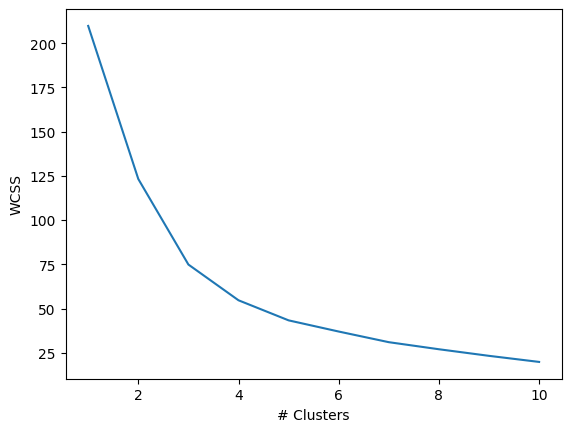

In [74]:
wcss = []

for i in range(1,11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
        kmeans.fit(reduced)
        wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.xlabel("# Clusters")
plt.ylabel("WCSS")
plt.show()


Now that we found an optimal number of clusters, we train the model.

In [75]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(reduced)

labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

We need to combine player names with 

In [76]:
players = players_90["Player"]

reduced['cluster'] = clusters
reduced['name'] = players
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced

,x,y,cluster,name
0,-0.172966,0.590845,3,Matías Abaldo
1,0.383197,0.436378,2,Luciano Abecasis
2,0.392697,0.908145,2,Jonás Acevedo
3,0.247691,-0.095545,0,Guillermo Acosta
4,-0.798566,-0.304148,1,Lucas Acosta
...,...,...,...,...
397,0.229153,-0.263853,0,Carlos Villalba
398,-0.333618,0.678421,3,Maximiliano Zalazar
399,0.589429,1.227483,2,Kevin Zenon
400,0.479426,0.041491,2,Bruno Zuculini
